In [1]:
import json
import pandas as pd
from utils import preprocessing, set_index
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from dc_vae_continual import DCVAE, Sampling
from utils import samples_conditions_embedd
import pickle
from statsmodels.graphics.tsaplots import plot_acf

2023-06-19 13:05:43.274807: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Settings

In [2]:
settings_path = 'settings/model_settings_reloj.txt'
settings = json.load(open(settings_path, 'r'))
print(settings)

{'dataset_name': 'TELCO', 'model_name': 'dc-vae_reloj', 'scale': False, 'wo_outliers': True, 'max_std': 7, 'T': 512, 'M': 12, 'cnn_units': [256, 256, 256, 256, 256, 256, 256, 256, 256], 'dil_rate': [1, 2, 4, 8, 16, 32, 64, 128, 256], 'kernel': 2, 'strs': 1, 'activation': 'selu', 'alpha_reg': 0.0001, 'batch_size': 32, 'J': 4, 'epochs': 200, 'lr': 0.0005, 'lr_decay': False, 'decay_rate': 0.96, 'decay_step': 7000, 'val_percent': 0.2, 'time_embedding': False, 'summary': True, 'save_best_model': False, 'save_complete_model': True}


### Train data

In [3]:

#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_train = ["TELCO_data_2021_01.zip", 
                "TELCO_data_2021_02.zip", "TELCO_data_2021_03.zip",
                #"TELCO_data_2021_04.zip", "TELCO_data_2021_05.zip", "TELCO_data_2021_06.zip",
                #"TELCO_data_2021_07.zip", "TELCO_data_2021_08.zip", "TELCO_data_2021_09.zip",
                #"TELCO_data_2021_10.zip", "TELCO_data_2021_11.zip", "TELCO_data_2021_12.zip"
                ]
files_train = [path+ i for i in filenames_train]

# Load data and predictions
# Read CSV files from List
data_train = pd.concat(map(pd.read_csv, files_train))
data_train = set_index(data_train)
data_train = preprocessing(data_train, flag_scaler=False, outliers=True)
data_train.head()

TS1       TS2       TS3       TS4       TS5  \
time                                                                    
2021-01-01 00:00:00  0.790423  0.572709  0.576859  0.786895  0.845216   
2021-01-01 00:05:00  0.774003  0.540110  0.576859  0.794884  0.843063   
2021-01-01 00:10:00  0.743711  0.532618  0.762395  0.809906  0.826144   
2021-01-01 00:15:00  0.768127  0.517837  0.762395  0.751709  0.834179   
2021-01-01 00:20:00  0.734526  0.495463  0.517999  0.664537  0.908283   

                          TS6       TS7       TS8       TS9  TS10      TS11  \
time                                                                          
2021-01-01 00:00:00  0.655201  0.723233  0.795858  0.407110  0.80  0.008386   
2021-01-01 00:05:00  0.717850  0.560724  0.650888  0.407110  0.80  0.008386   
2021-01-01 00:10:00  0.639912  0.530483  0.618343  0.407110  0.80  0.008386   
2021-01-01 00:15:00  0.641776  0.538414  0.603550  0.103483  0.45  0.001316   
2021-01-01 00:20:00  1.184732  0.501817  0.568047  0.103483  0.45  0.001316   

                         TS12  
time                           
2021-01-01 00:00:00  0.010724  
2021-01-01 00:05:00  0.010724  
2021-01-01 00:10:00  0.010724  
2021-01-01 00:15:00  0.008043  
2021-01-01 00:20:00  0.008043

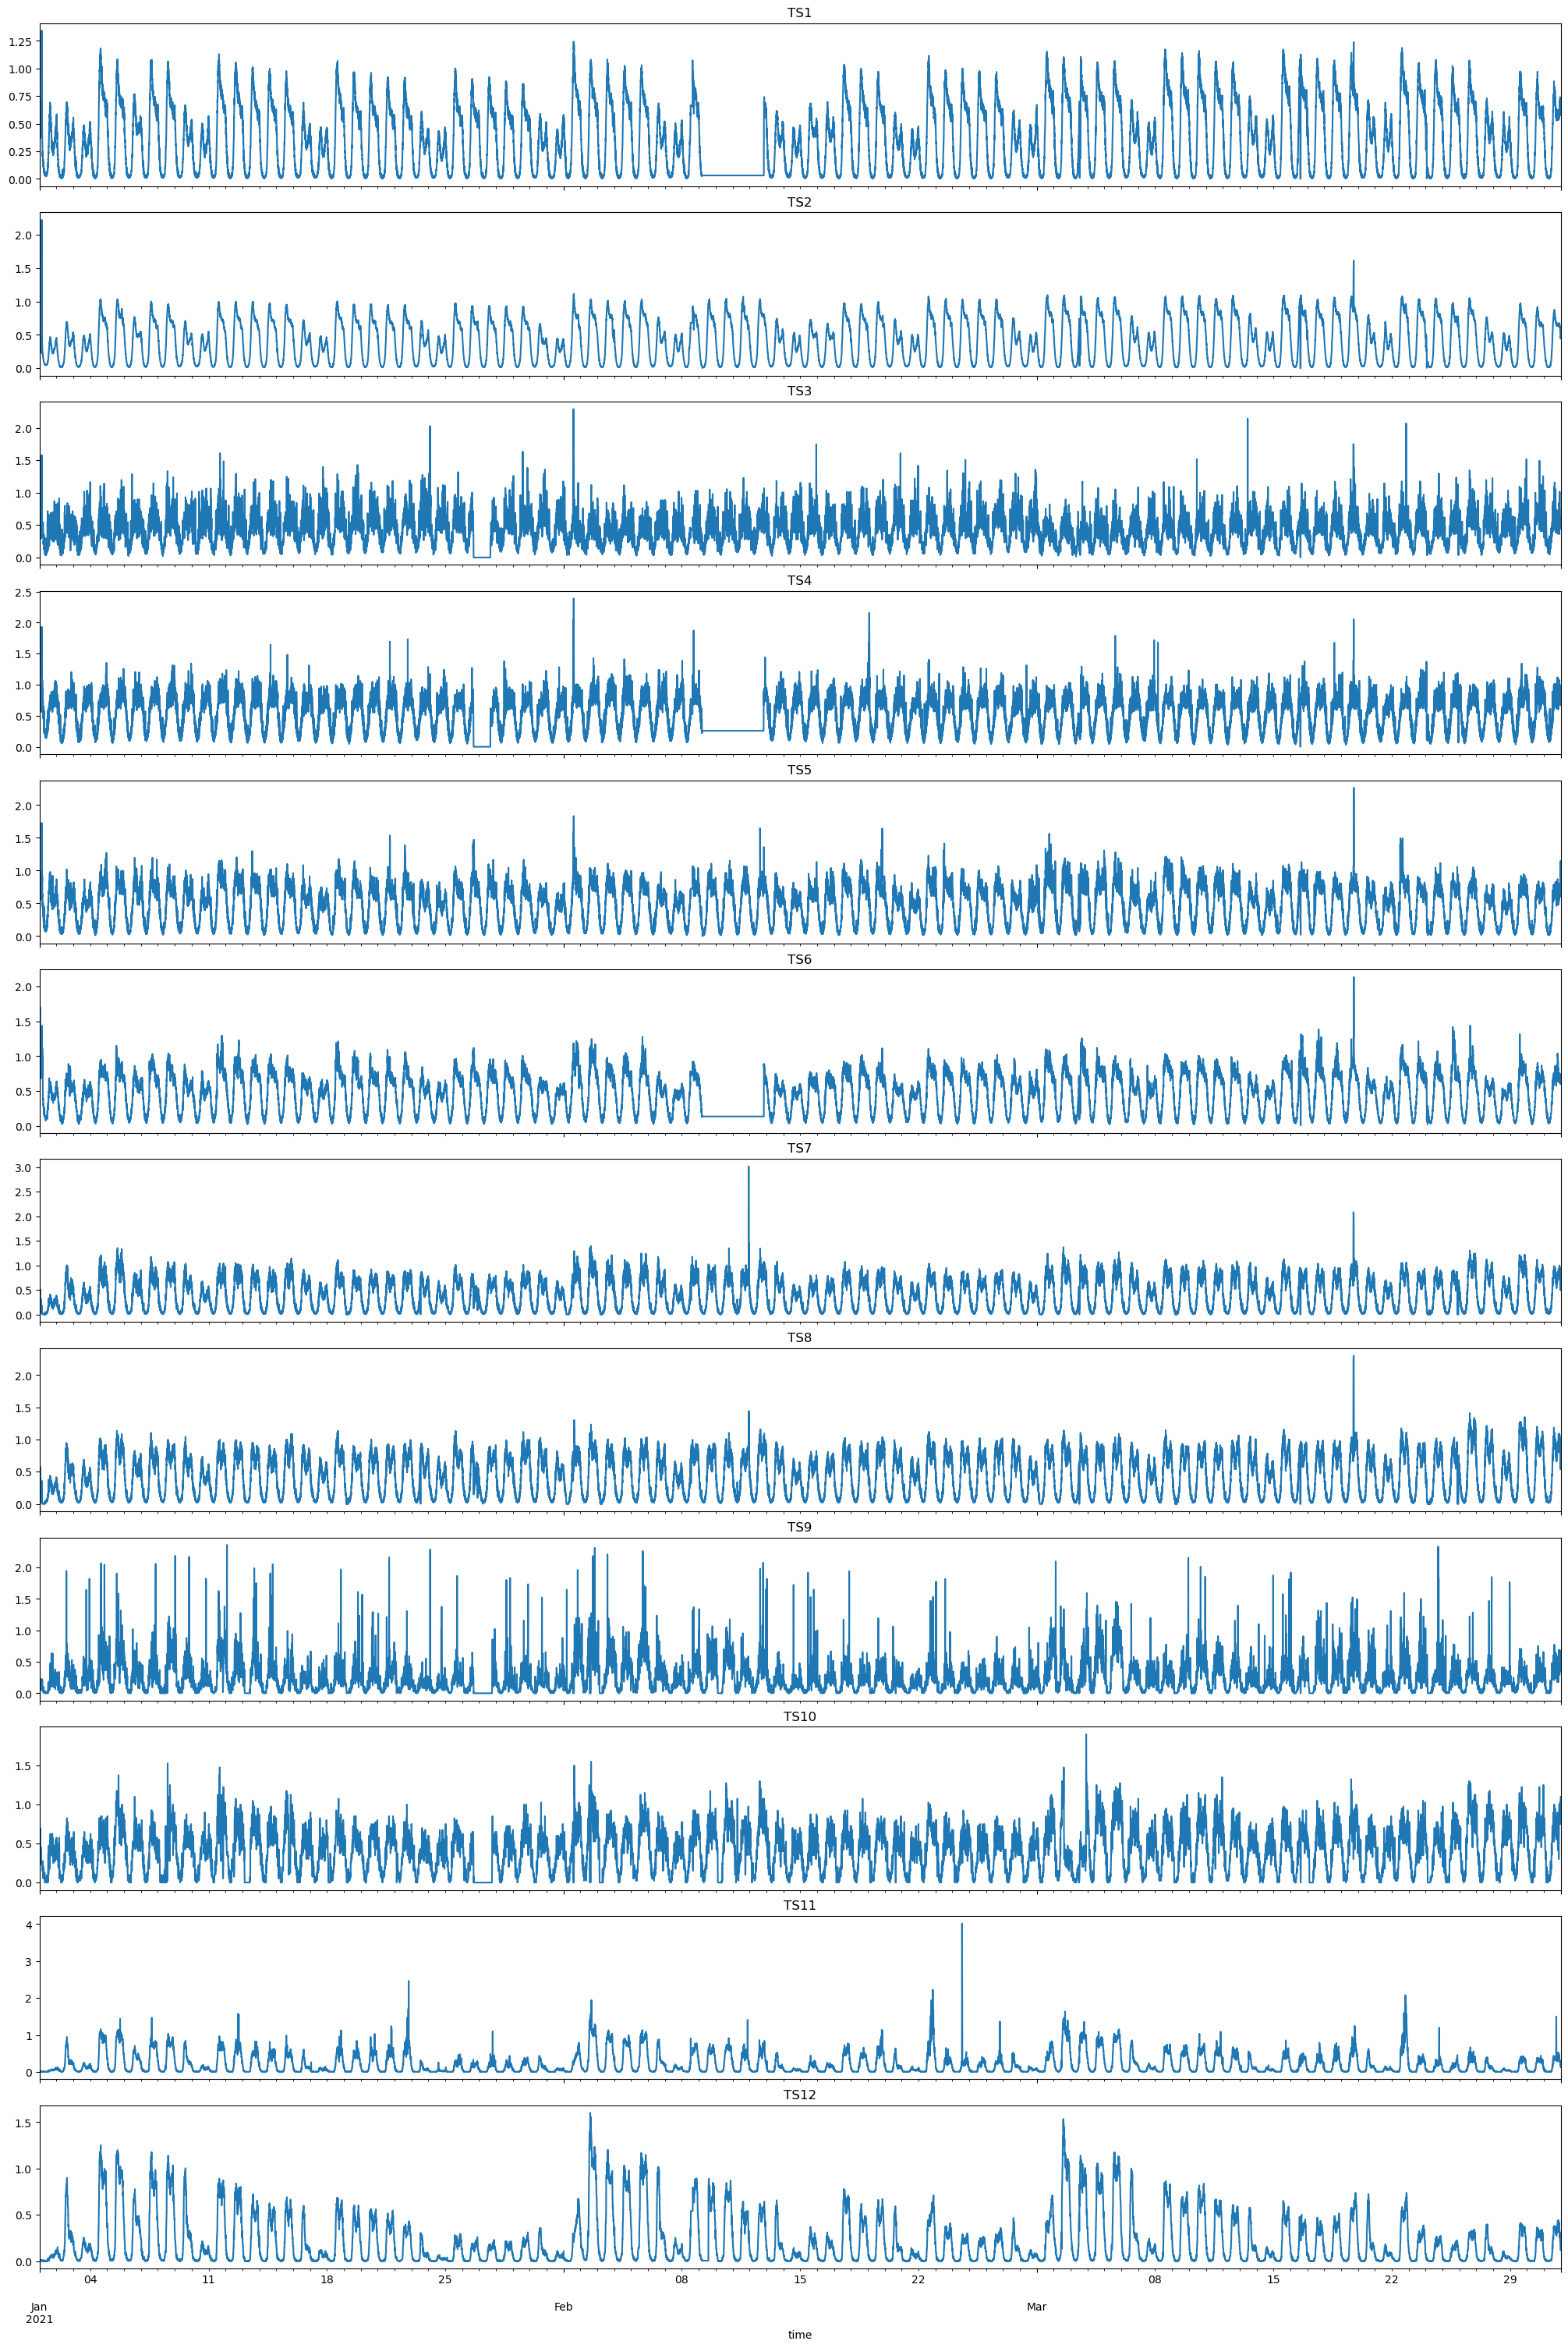

In [4]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data_train.columns

time_start = '2021-01-01'
time_end = '2021-12-31'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_train[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

## Predicciones

In [5]:

encoder = keras.models.load_model(settings['model_name']+'_encoder.h5',
                                                custom_objects={'sampling': Sampling},
                                                compile = True)

2023-06-19 13:05:51.319281: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-19 13:05:51.320002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-19 13:05:51.331474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-19 13:05:51.331740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-06-19 13:05:51.331758: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-19 13:05:51.333290: I tensorflow/stream_executor/platform/default/d

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 12)]    0                                            
__________________________________________________________________________________________________
cnn_0 (Conv1D)                  (None, 512, 128)     3200        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 128)     512         cnn_0[0][0]                      
__________________________________________________________________________________________________
cnn_1 (Conv1D)                  (None, 512, 128)     32896       batch_normalization[0][0]        
____________________________________________________________________________________________

In [7]:

decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
                                                custom_objects={'sampling': Sampling},
                                                compile = True)

In [8]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_sampling (InputLayer)         [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
cnn_-1 (Conv1DTranspose)        (None, 257, 4)       36          z_sampling[0][0]                 
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 257, 4)       16          cnn_-1[0][0]                     
__________________________________________________________________________________________________
cnn_-2 (Conv1DTranspose)        (None, 385, 16)      144         batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [9]:
X = data_train.values
N = data_train.shape[0]
X = np.array([X[i: i + settings['T']] for i in range(0, N - settings['T']+1)])

z_mu_train, z_log_var_train, z_train = encoder.predict(X)
z_sig_train = np.exp(0.5*z_log_var_train)

2023-06-19 13:05:53.418699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-19 13:05:53.418970: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2023-06-19 13:05:53.622695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-19 13:05:54.106747: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-19 13:05:54.185048: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-06-19 13:05:54.749314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


### Ejemplo de como se agrupan los puntos por hora

### $\mu_z$

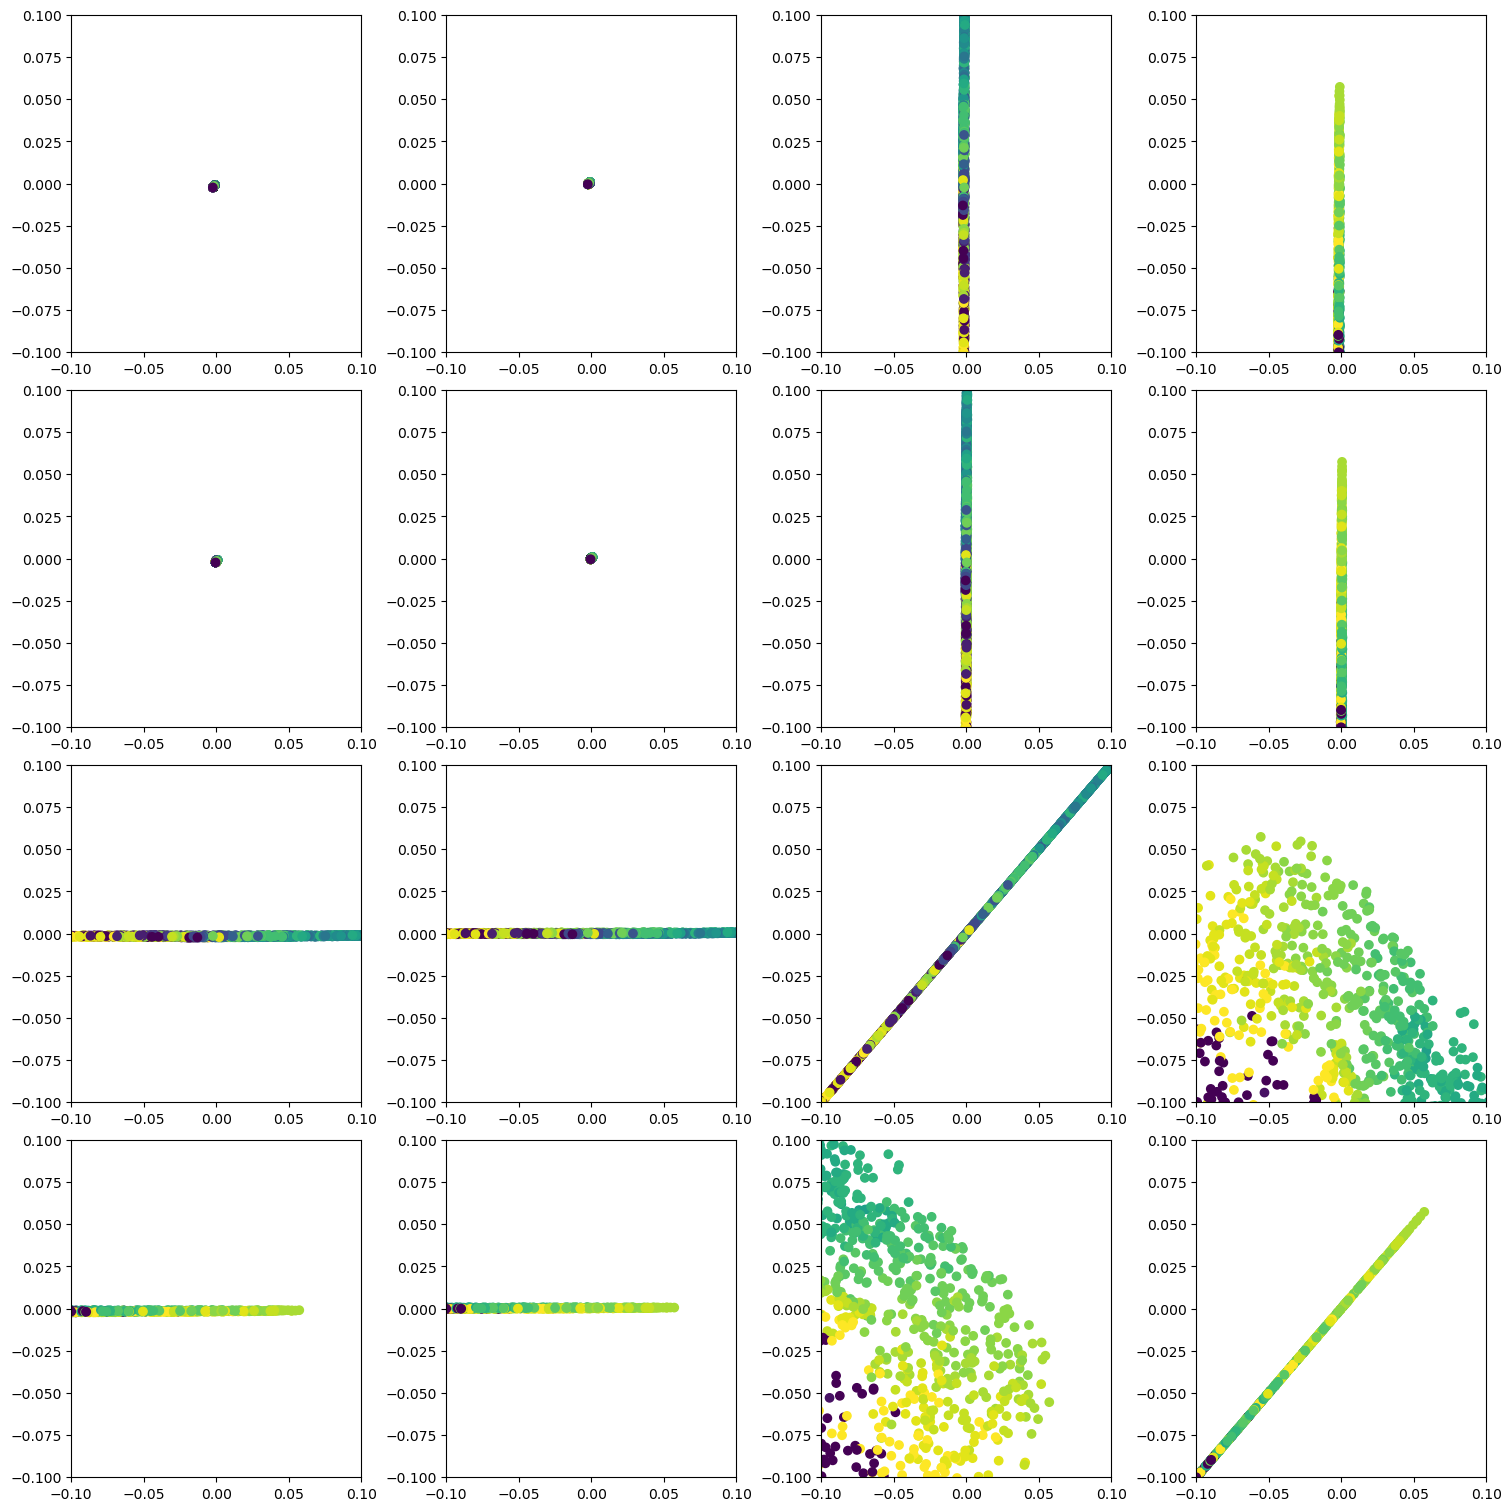

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(15,15), constrained_layout=True)

ix_rand = np.random.permutation(len(z_mu_train))

N=2000

data_aux = data_train[(settings['T']-1):]

for i in range(4):
    for j in range(4):
        axes[i,j].scatter(z_mu_train[ix_rand[:N], -1, i], 
                          z_mu_train[ix_rand[:N], -1, j], 
                          c=data_aux.index.hour[ix_rand[:N]])
        axes[i,j].set_ylim((-0.1, 0.1))
        axes[i,j].set_xlim((-0.1, 0.1))

### $\sigma_z$

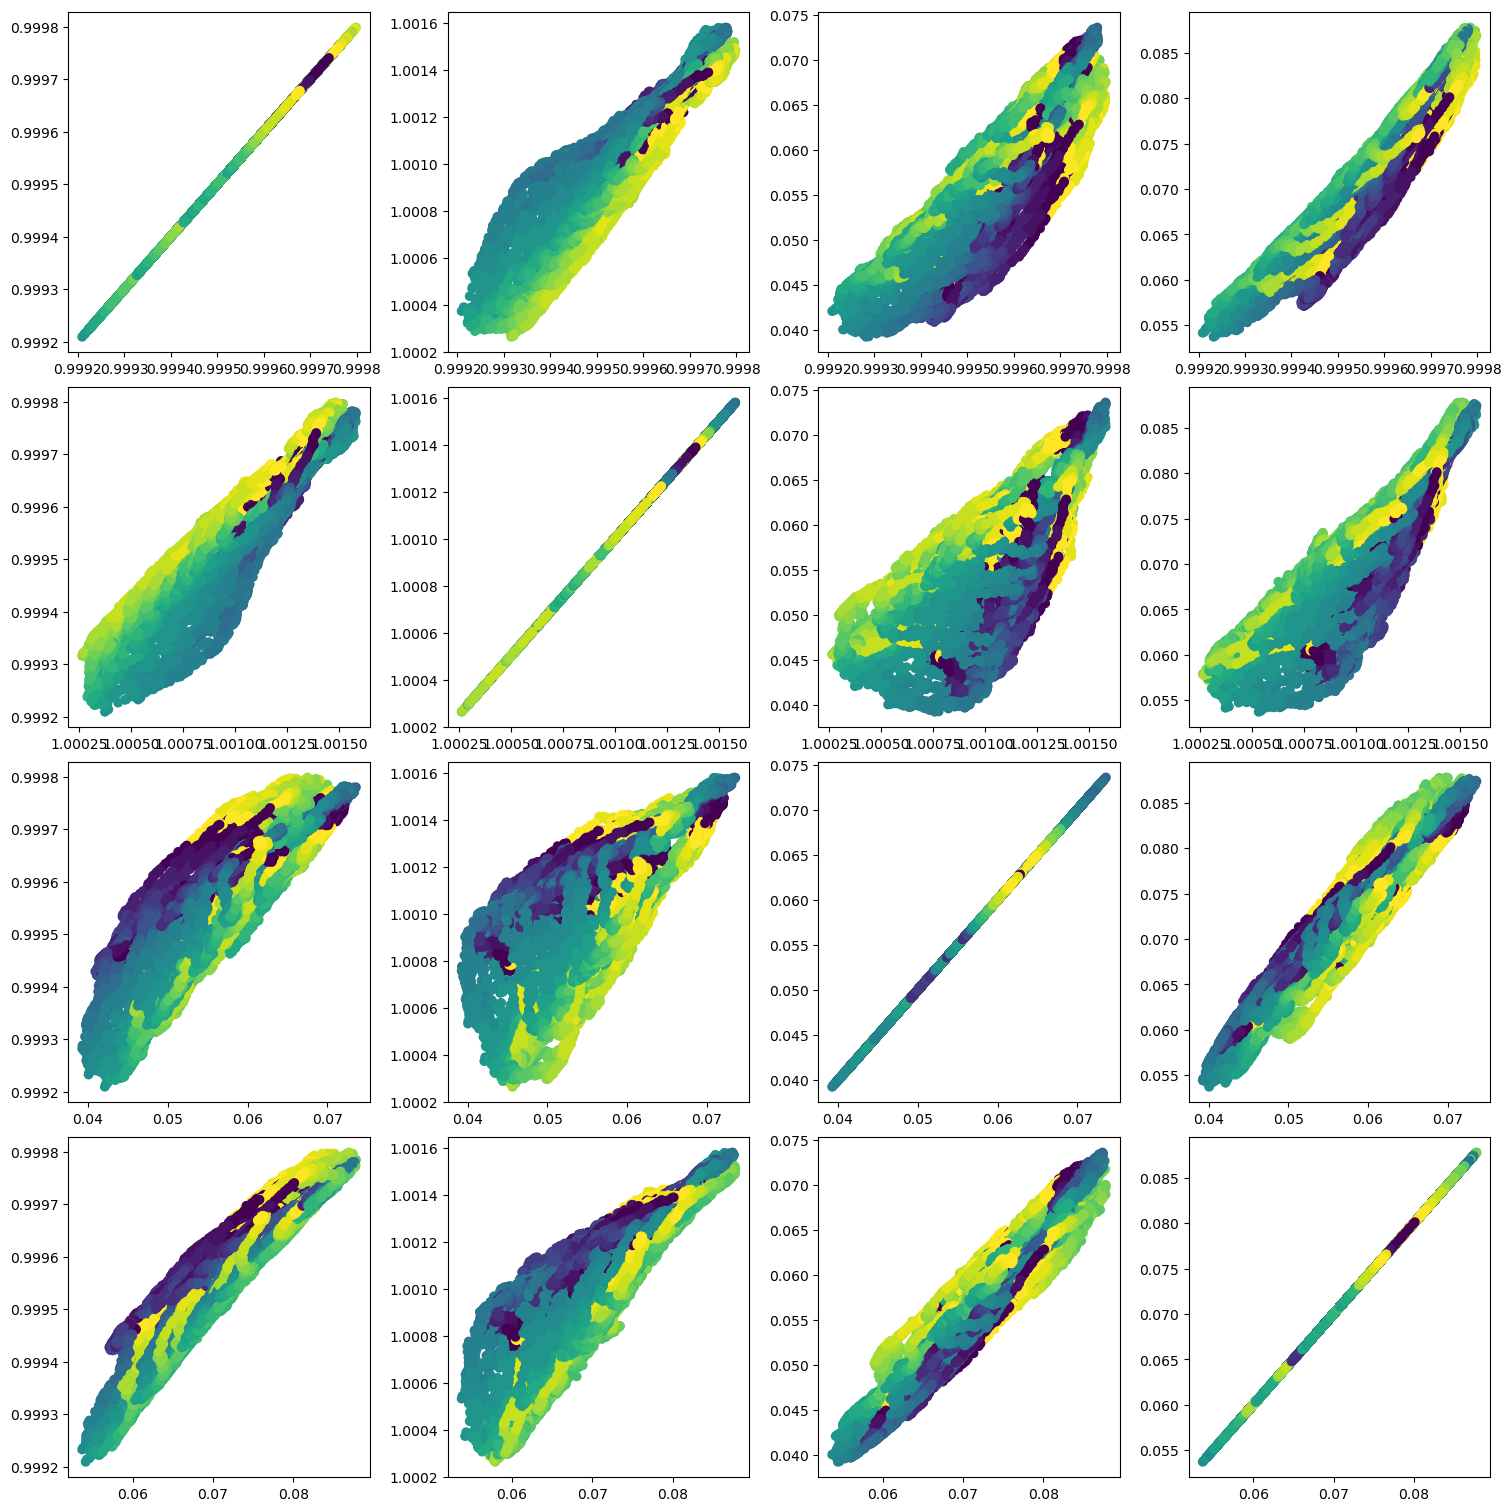

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15,15), constrained_layout=True)

for i in range(4):
    for j in range(4):
        axes[i,j].scatter(z_sig_train[:, -1, i], 
                          z_sig_train[:, -1, j], 
                          c=data_train.index.hour[(settings['T']-1):])

### $z$

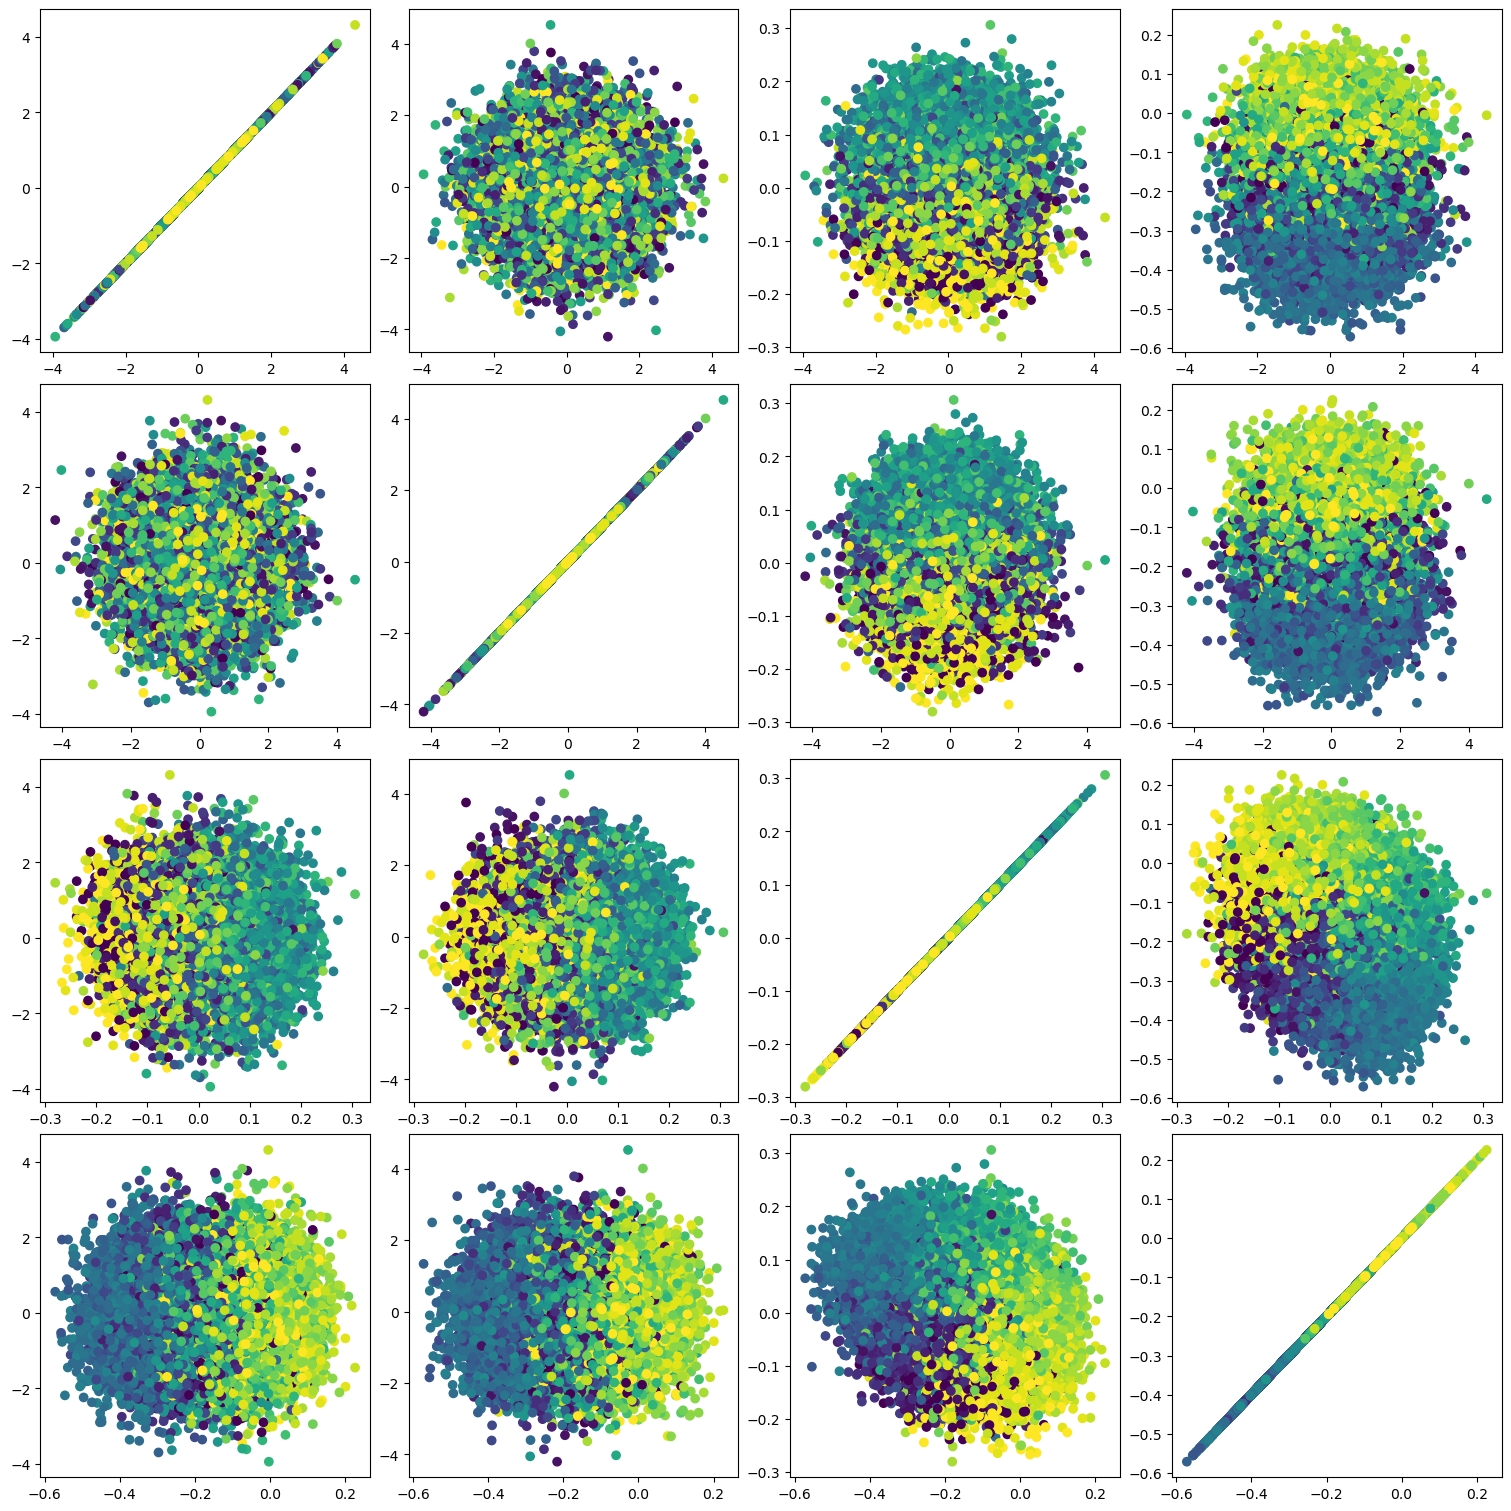

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15,15), constrained_layout=True)

for i in range(4):
    for j in range(4):
        axes[i,j].scatter(z_train[:, -1, i], 
                          z_train[:, -1, j], 
                          c=data_train.index.hour[(settings['T']-1):])